---
# title: "My Notebook"
format:
  html:
    toc: true           # ✅ Table of contents (outline)
    toc-location: left  # ✅ Place TOC in the left sidebar
    number-sections: true
    code-fold: true
    code-summary: "Show Code"
    theme: cosmo        # Optional themes: cosmo, flatly, default, etc.
---

# Week 5A<br>Geospatial Data: Raster

Sep 25, 2025

In [3]:
# Our usual imports
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
# This will add the .hvplot() function to your DataFrame!
# Import holoviews too
import holoviews as hv
import hvplot.pandas

hv.extension("bokeh")

## We've already worked with *raster* data!

- So far we've been working mainly with *vector* data using geopandas: lines, points, polygons
- The basemap tiles we've been adding to our `hvplot` maps are an exampe of *raster* data
- **Raster data:**
    - Gridded or pixelated
    - Maps easily to an array — it's the representation for digital images

<img src="imgs/raster-intro.png" width=800></img>

## Continuous raster examples

- Multispectral satellite imagery, e.g., the Landsat satellite
- Digital Elevation Models (DEMs)
- Maps of canopy height derived from LiDAR data.

## Categorical raster examples

- Land cover or land-use maps.
- Tree height maps classified as short, medium, and tall trees.
- Snowcover masks (binary snow or no snow)

## Important attributes of raster data

### 1. The coordinate reference system 

![](imgs/raster-crs.jpeg)

### 2. Resolution

The spatial distance that a single pixel covers on the ground.

![](imgs/raster-resolution.png)

### 3. Extent

The bounding box that covers the entire extent of the raster data.

<img src="imgs/raster-extent.png" width=700></img>

<img src="imgs/raster-extent-2.png" width=700></img>

### 4. Affine transformation

Transform from *pixel space* to *real space*

- A mapping from pixel space (rows and columns of the image) to the x and y coordinates defined by the CRS
- Typically a six parameter matrix defining the origin, pixel resolution, and rotation of the raster image

## Multi-band raster data

Each band measures the light reflected from different parts of the electromagnetic spectrum. 

![](imgs/multi-band-raster.png)

Color images are multi-band rasters!

<img src="imgs/color-images.png" width="800"></img>

## The raster format: GeoTIFF

- A standard `.tif` image format with additional spatial information embedded in the file, which includes metadata for: 
    - Geotransform, e.g., extent, resolution
    - Coordinate Reference System (CRS)
    - Values that represent missing data (`NoDataValue`)

## Tools for raster data 

- Lots of different options: really just working with *arrays*
- One of the first options: Geospatial Data Abstraction Library (GDAL)
    - Low level and not really user-friendly
- A more recent, much more Pythonic package: `rasterio`

We'll use `rasterio` for the majority of our raster analysis

::: {.callout-note title="Raster data + NumPy"}

Multi-band raster data is best represented as multi-dimensional arrays. In Python, that means working with NumPy arrays. We'll work primarily with rasterio today but see a few examples of NumPy arrays.

To learn more about NumPy, we recommend going through the 
[DataCamp course on NumPy](https://www.datacamp.com/courses/introduction-to-numpy). To get free access to DataCamp, see [the instructions](https://musa-550-fall-2023.github.io/resource/python.html#datacamp-courses) on the course website.

:::

## Part 1: Getting started with rasterio

Analysis is built around the "open()" command which returns a "dataset" or "file handle". For the satellite imagery, please download from [here](data/landsat8_philly.tif).


In [5]:
import rasterio as rio

In [6]:
# Open the file and get a file "handle"
landsat = rio.open("./data/landsat8_philly.tif")

landsat

<open DatasetReader name='./data/landsat8_philly.tif' mode='r'>

### Let's check out the metadata


In [7]:
# The CRS
landsat.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]')

In [8]:
# The bounds
landsat.bounds

BoundingBox(left=476064.3596176505, bottom=4413096.927074196, right=503754.3596176505, top=4443066.927074196)

In [9]:
# The number of bands available
landsat.count

10

In [10]:
# The band numbers that are available
landsat.indexes

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

In [11]:
# Number of pixels in the x and y directions
landsat.shape

(999, 923)

(a, b, c, d, e, f) = landsat.transform

- a = pixel width (x-resolution, size of a pixel in the x direction)
- b = row rotation (usually 0, unless the image is rotated/skewed)
- c = x-coordinate of the upper-left corner of the upper-left pixel
- d = column rotation (usually 0)
- e = pixel height (y-resolution, negative if the origin is top-left)
- f = y-coordinate of the upper-left corner of the upper-left pixel

In [12]:
# The 6 parameters that map from pixel to real space,
landsat.transform

Affine(30.0, 0.0, 476064.3596176505,
       0.0, -30.0, 4443066.927074196)

In [13]:
# All of the meta data
landsat.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 923,
 'height': 999,
 'count': 10,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'),
 'transform': Affine(30.0, 0.0, 476064.3596176505,
        0.0, -30.0, 4443066.927074196)}

### Reading data from a file

Tell the file which band to read, **starting with 1**

In [14]:
# This is a NumPy array!
data = landsat.read(1)

data

array([[10901, 10618, 10751, ..., 12145, 11540, 14954],
       [11602, 10718, 10546, ..., 11872, 11982, 12888],
       [10975, 10384, 10357, ..., 11544, 12318, 12456],
       ...,
       [12281, 12117, 12072, ..., 11412, 11724, 11088],
       [12747, 11866, 11587, ..., 11558, 12028, 10605],
       [11791, 11677, 10656, ..., 10615, 11557, 11137]],
      shape=(999, 923), dtype=uint16)

### Plotting with imshow

We can plot it with matplotlib's `imshow`

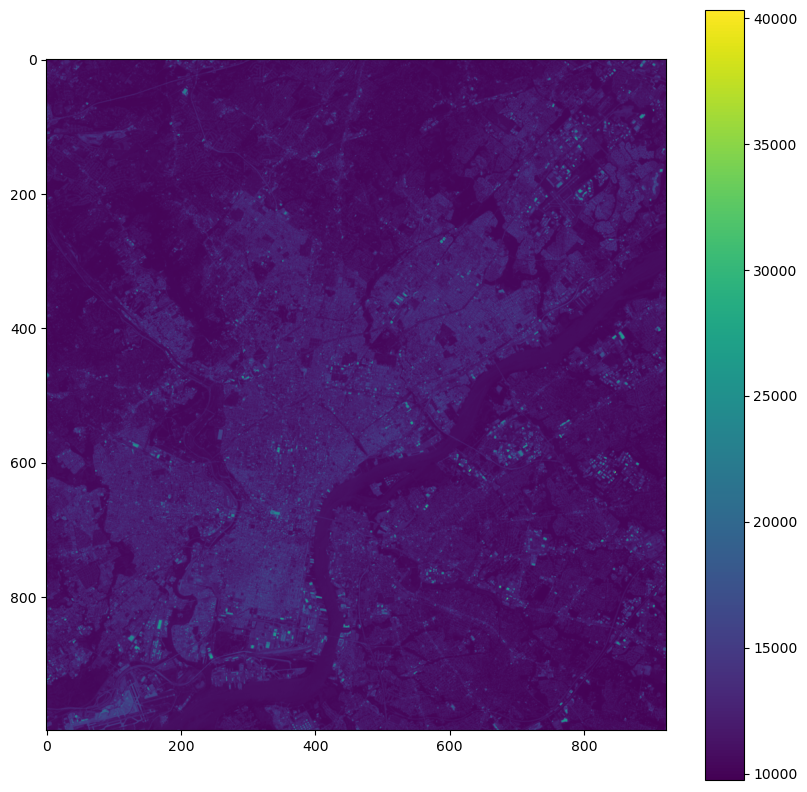

In [15]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

img = ax.imshow(data)

plt.colorbar(img)

### Two improvements

- A log-scale colorbar
- Add the axes extent

#### 1. Adding the axes extent

Note that imshow needs a bounding box of the form: `(left, right, bottom, top).` 


See the documentation for `imshow` if you forget the right ordering...(I often do!)

#### 2. Using a log-scale color bar

Matplotlib has a built in log normalization...

In [16]:
import matplotlib.colors as mcolors

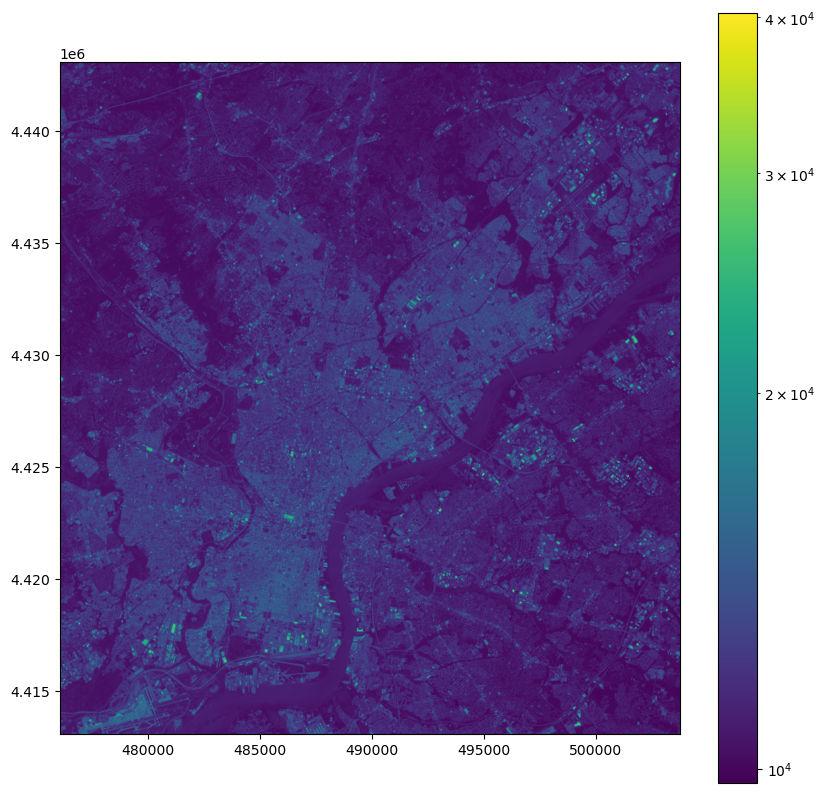

In [17]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the image
img = ax.imshow(
    data,
    # Use a log colorbar scale
    norm=mcolors.LogNorm(),
    # Set the extent of the images
    extent=[
        landsat.bounds.left,
        landsat.bounds.right,
        landsat.bounds.bottom,
        landsat.bounds.top,
    ],
)

# Add a colorbar
plt.colorbar(img)

### Overlaying vector geometries on raster plots

Two requirements:

1. The CRS of the two datasets must match
1. The extent of the imshow plot must be set properly

#### Example: Let's add the city limits

The city limit shapefile can be downloaded from [here](data/City_Limits.geojson). Make sure put all the data files in the same folder as this notebook.

In [2]:
import geopandas as gpd

city_limits = gpd.read_file("./data/City_Limits.geojson")


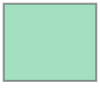

In [11]:
city_limits.envelope[0]

In [3]:
# Convert to the correct CRS!
print(landsat.crs.to_epsg())

NameError: name 'landsat' is not defined

In [20]:
city_limits = city_limits.to_crs(epsg=landsat.crs.to_epsg())

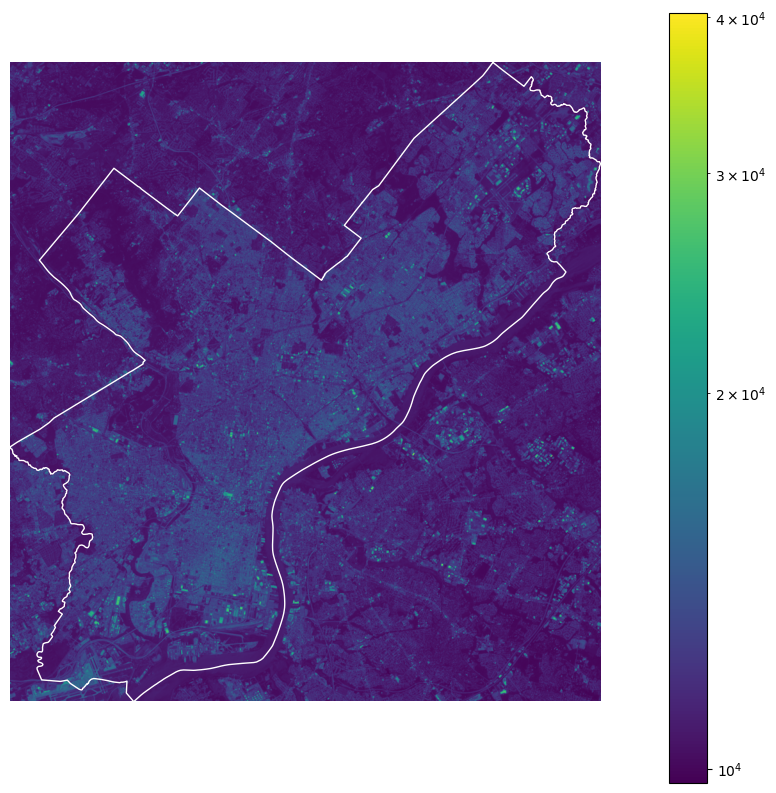

In [21]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# The extent of the data
landsat_extent = [
    landsat.bounds.left,
    landsat.bounds.right,
    landsat.bounds.bottom,
    landsat.bounds.top,
]

# Plot!
img = ax.imshow(data, norm=mcolors.LogNorm(), extent=landsat_extent)

# Add the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="white")

# Add a colorbar and turn off axis lines
plt.colorbar(img)
ax.set_axis_off()

**But wait...** What band did we plot??

Landsat 8 has 11 bands spanning the electromagnetic spectrum from visible to infrared. 

<img src="imgs/landsat-bands.png" width="700"></img>

### How about a typical RGB color image?

First let's read the red, blue, and green bands (bands 4, 3, 2):

::: {.callout-note}

The `.indexes` attributes tells us the bands available to be read.

**Important:** they are **NOT** zero-indexed! 

:::

In [22]:
landsat.indexes

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

In [23]:
rgb_data = landsat.read([4, 3, 2])

In [24]:
rgb_data.shape

(3, 999, 923)

Note the data has the shape: (bands, height, width)

In [25]:
rgb_data[0]

array([[ 8908,  7860,  8194, ..., 10387,  9995, 15829],
       [ 9209,  8077,  7657, ...,  9479,  9869, 11862],
       [ 8556,  7534,  7222, ...,  9140, 10283, 10836],
       ...,
       [10514, 10525, 10753, ...,  9760, 10667,  9451],
       [11503, 10408,  9317, ...,  9646, 10929,  8503],
       [10089,  9496,  7862, ...,  8222, 10221, 10160]],
      shape=(999, 923), dtype=uint16)

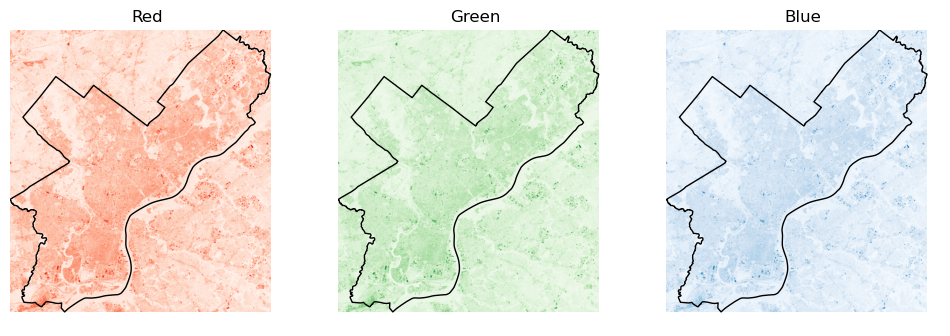

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

cmaps = ["Reds", "Greens", "Blues"]
for i in [0, 1, 2]:
    
    # This subplot axes
    ax = axs[i]
    
    # Plot
    ax.imshow(rgb_data[i], norm=mcolors.LogNorm(), extent=landsat_extent, cmap=cmaps[i])
    city_limits.plot(ax=ax, facecolor="none", edgecolor="black")

    # Format
    ax.set_axis_off()
    ax.set_title(cmaps[i][:-1])

::: {.callout-tip}

# Side note: using subplots in matplotlib

You can specify the subplot layout via the `nrows` and `ncols` keywords to `plt.subplots`. If you have more than one row or column, the function returns: 
- The figure
- The **list of axes**.

:::

As an example:

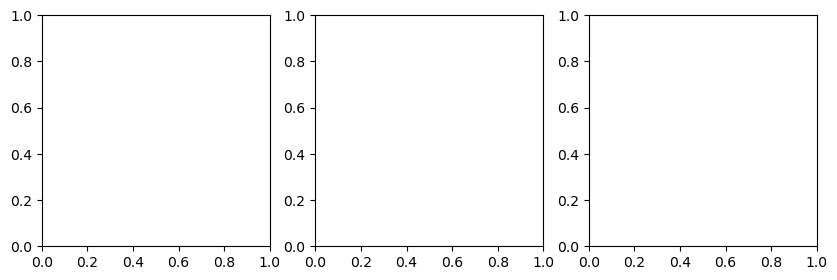

In [27]:
fig, axs = plt.subplots(figsize=(10, 3), nrows=1, ncols=3)

::: {.callout-note}

When `nrows` or `ncols` > 1, I usually name the returned axes variable "axs" vs. the usual case of just "ax". It's useful for remembering we got more than one Axes object back!

:::

In [28]:
# This has length 3 for each of the 3 columns!
axs

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

In [29]:
# Left axes
axs[0]

<Axes: >

In [30]:
# Middle axes
axs[1]

<Axes: >

In [31]:
# Right axes
axs[2]

<Axes: >

### Use `earthpy` to plot the combined color image

A useful utility package to perform the proper re-scaling of pixel values

In [32]:
# !pip install earthpy

In [33]:
import earthpy.plot as ep

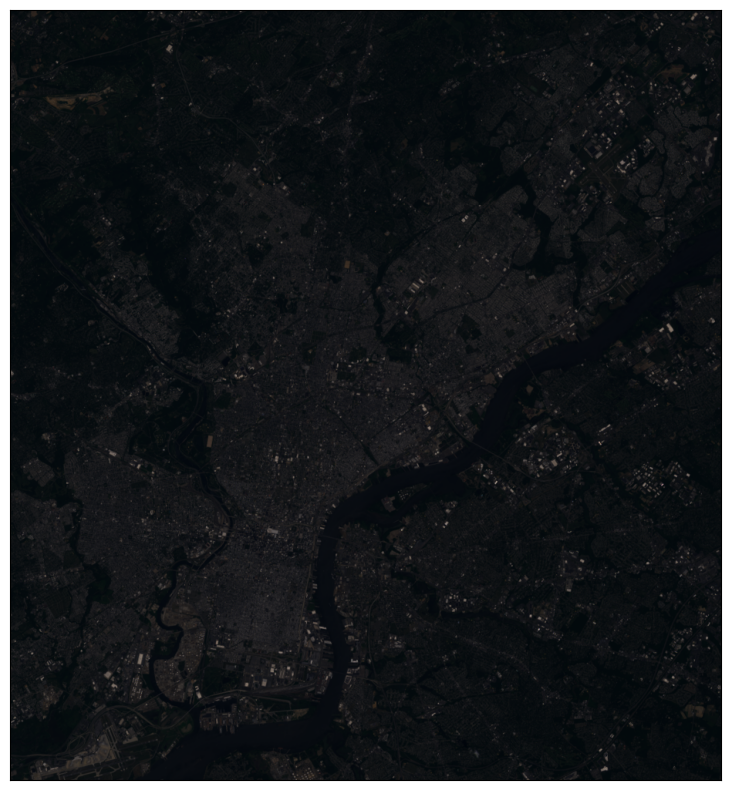

In [34]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the RGB bands
ep.plot_rgb(rgb_data, rgb=(0, 1, 2), ax=ax);

#### We can "stretch" the data to improve the brightness

<img src="imgs/earthpy-stretch.png" width="700"></img>

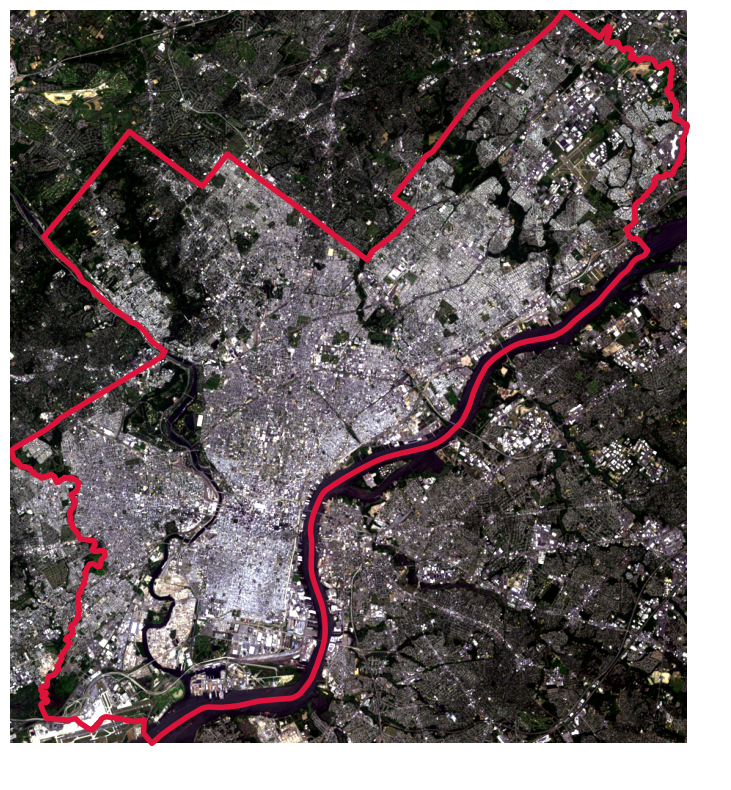

In [35]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the RGB bands
ep.plot_rgb(rgb_data, rgb=(0, 1, 2), ax=ax, stretch=True, extent=landsat_extent)

# Add the city limits
city_limits.plot(ax=ax, facecolor="none", edgecolor="crimson", linewidth=4)

# Remove axes
ax.set_axis_off()

### Conclusion: Working with multi-band data via rasterio is a bit messy

Can we do better?

**Yes!**

HoloViz to the rescue...

The xarray package is an alternative way to work with raster data. It's not as well established as `rasterio` but has a lot of promising features...

<img src="imgs/xarray-logo.png" width="600"></img>

### A quick example with xarray

- A fancier version of NumPy arrays
- Designed for gridded data with multiple dimensions
- For raster data, those dimensions are: bands, latitude, longitude, pixel values

In [36]:
# !pip install rioxarray

In [37]:
import rioxarray  # Adds rasterio engine extension to xarray
import xarray as xr

In [38]:
ds = xr.open_dataset("./data/landsat8_philly.tif", engine="rasterio")

ds

<xarray.Dataset> Size: 37MB
Dimensions:      (band: 10, x: 923, y: 999)
Coordinates:
  * band         (band) int64 80B 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 7kB 4.761e+05 4.761e+05 ... 5.037e+05 5.037e+05
  * y            (y) float64 8kB 4.443e+06 4.443e+06 ... 4.413e+06 4.413e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 37MB ...

In [39]:
type(ds)

xarray.core.dataset.Dataset

### Now the magic begins: more hvplot

Still experimental, but very promising — interactive plots with widgets for each band!

In [40]:
import hvplot.xarray

In [44]:
# !pip install jupyter_bokeh

In [ ]:
img = ds.hvplot.image(y='y', x='x', width=700, height=500, cmap="viridis")

img

BokehModel(combine_events=True, render_bundle={'docs_json': {'47d97eac-54e0-4bd9-9c36-f22d036ebdd3': {'version…

More magic widgets from hvplot!

### That's it for xarray for now...


More coming in later when we tackle advanced raster examples...

## Part 2: Two key raster concepts

- Combining vector + raster data
    - Cropping or masking raster data based on vector polygons
- Raster math and zonal statistics
    - Combining multiple raster data sets
    - Calculating statistics within certain vector polygons

### Cropping: let's trim to just the city limits

Use rasterio's builtin `mask()` function:

In [47]:
from rasterio.mask import mask

In [48]:
landsat

<open DatasetReader name='./data/landsat8_philly.tif' mode='r'>

In [49]:
city_limits.geometry

0    POLYGON ((498724.96 4443066.927, 498759.458 44...
Name: geometry, dtype: geometry

In [50]:
masked, mask_transform = mask(
    dataset=landsat,              # The original raster data
    shapes=city_limits.geometry,  # The vector geometry we want to crop by
    crop=True,                    # Optional: remove pixels not within boundary
    all_touched=True,             # Optional: get all pixels that touch the boudnary
    filled=False,                 # Optional: do not fill cropped pixels with a default value
)

In [51]:
masked

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],

        ...,

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --,

In [52]:
masked.shape

(10, 999, 923)

Let's plot the masked data:

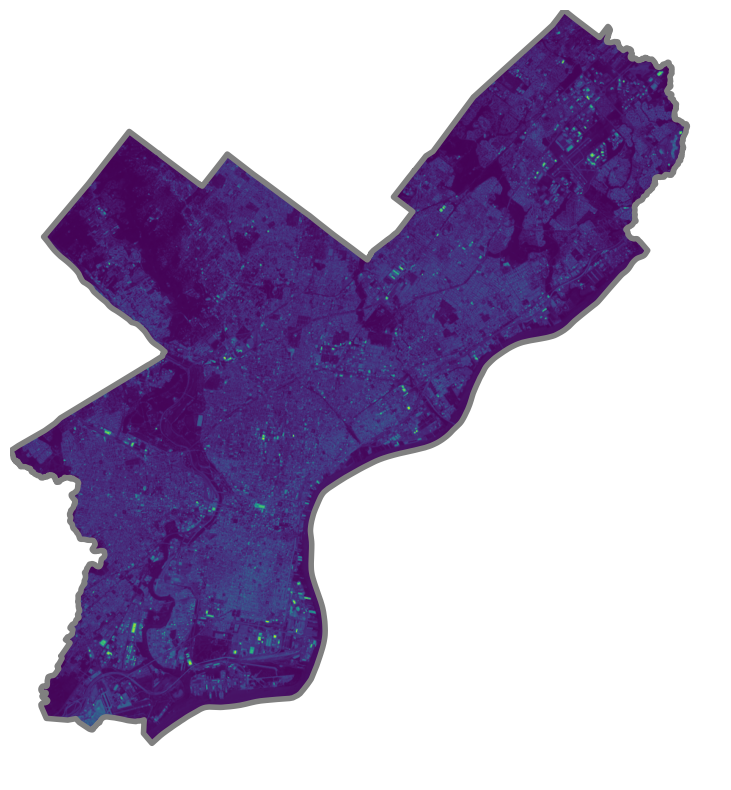

In [53]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the first band
ax.imshow(masked[0], cmap="viridis", extent=landsat_extent)

# Format and add the city limits
city_limits.boundary.plot(ax=ax, color="gray", linewidth=4)
ax.set_axis_off()

### Writing GeoTIFF files

Let's save our cropped raster data. To save raster data, we need both the array of the data and the proper meta-data. 

In [54]:
# The original meta dict
out_meta = landsat.meta

# Call dict.update() to add new key/value pairs
out_meta.update(
    {"height": masked.shape[1], 
     "width": masked.shape[2], 
     "transform": mask_transform
    }
)

# Print out new meta
print(out_meta)

# Write small image to local Geotiff file
with rio.open("data/cropped_landsat.tif", "w", **out_meta) as dst:
    print("dst = ", dst)
    dst.write(masked)
    

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 923, 'height': 999, 'count': 10, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'), 'transform': Affine(30.0, 0.0, 476064.3596176505,
       0.0, -30.0, 4443066.927074196)}
dst =  <open DatasetWriter name='data/cropped_landsat.tif' mode='w'>


In [55]:
# Note: dst is now closed — we can't access it any more!
dst

<closed DatasetWriter name='data/cropped_landsat.tif' mode='w'>

::: {.callout-note}

We used a *context manager* above (the "with" statement) to handle the opening and subsequent closing of our new file.

For more info, see [this tutorial](https://www.pythontutorial.net/advanced-python/python-context-managers/).

:::

### Now, let's do some raster math

Often called "map algebra"...

### The Normalized Difference Vegetation Index

- A normalized index of greenness ranging from -1 to 1, calculated from the red and NIR bands. 
- Provides a measure of the amount of live green vegetation in an area

**Formula:**

NDVI = (NIR - Red) / (NIR + Red)

**How to intepret:** Healthy vegetation reflects NIR and absorbs visible, so the NDVI for green vegatation is +1

#### Get the data for the red and NIR bands

NIR is band 5 and red is band 4

In [56]:
masked.shape

(10, 999, 923)

In [57]:
# Note that the indexing here is zero-based, e.g., band 1 is index 0
red = masked[3]
nir = masked[4]

In [58]:
# Where mask = True, pixels are excluded
red.mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(999, 923))

In [59]:
# Get valid entries
check = np.logical_and(red.mask == False, nir.mask == False)

check

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(999, 923))

In [60]:
def calculate_NDVI(nir, red):
    """
    Calculate the NDVI from the NIR and red landsat bands
    """

    # Convert to floats
    nir = nir.astype(float)
    red = red.astype(float)

    # Get valid entries
    check = np.logical_and(red.mask == False, nir.mask == False)

    # Where the check is True, return the NDVI, else return NaN
    ndvi = np.where(check, (nir - red) / (nir + red), np.nan)
    
    # Return
    return ndvi

In [61]:
NDVI = calculate_NDVI(nir, red)

Text(0.5, 1.0, 'NDVI in Philadelphia')

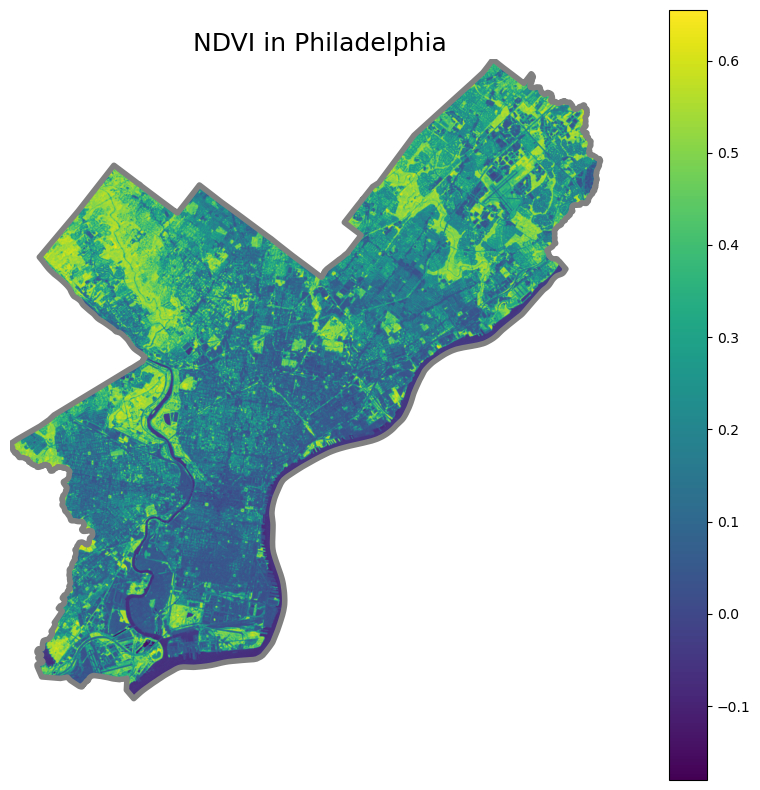

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot NDVI
img = ax.imshow(NDVI, extent=landsat_extent)

# Format and plot city limits
city_limits.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=4)
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("NDVI in Philadelphia", fontsize=18)

#### Let's overlay Philly's parks

The park file can be downloaded from [here](data/parks.geojson).

In [63]:
# Read in the parks dataset
parks = gpd.read_file("./data/parks.geojson")

In [64]:
parks.head()

OBJECTID               ASSET_NAME                SITE_NAME  \
0         7  Wissahickon Valley Park  Wissahickon Valley Park   
1         8      West Fairmount Park      West Fairmount Park   
2        23           Pennypack Park           Pennypack Park   
3        24      East Fairmount Park      East Fairmount Park   
4        25        Tacony Creek Park        Tacony Creek Park   

                  CHILD_OF ADDRESS  TYPE                             USE_  \
0  Wissahickon Valley Park    None  LAND  REGIONAL_CONSERVATION_WATERSHED   
1      West Fairmount Park          LAND  REGIONAL_CONSERVATION_WATERSHED   
2           Pennypack Park          LAND  REGIONAL_CONSERVATION_WATERSHED   
3      East Fairmount Park          LAND  REGIONAL_CONSERVATION_WATERSHED   
4        Tacony Creek Park          LAND  REGIONAL_CONSERVATION_WATERSHED   

  DESCRIPTION       SQ_FEET      ACREAGE  ZIPCODE  \
0  NO_PROGRAM  9.078309e+07  2084.101326    19128   
1  NO_PROGRAM  6.078159e+07  1395.358890    19131   
2  NO_PROGRAM  6.023748e+07  1382.867808    19152   
3  NO_PROGRAM  2.871642e+07   659.240959    19121   
4  NO_PROGRAM  1.388049e+07   318.653500    19120   

                          ALLIAS NOTES TENANT                    LABEL  \
0                                  MAP   SITE  Wissahickon Valley Park   
1                                  MAP   SITE      West Fairmount Park   
2  Verree Rd Interpretive Center   MAP   SITE           Pennypack Park   
3                                  MAP   SITE      East Fairmount Park   
4                                  MAP   SITE        Tacony Creek Park   

   DPP_ASSET_ID   Shape__Area  Shape__Length  \
0          1357  1.441162e+07   71462.556702   
1          1714  9.631203e+06   25967.819064   
2          1651  9.566914e+06   41487.394790   
3          1713  4.549582e+06   21499.126097   
4          1961  2.201840e+06   19978.610852   

                                            geometry  
0  MULTIPOLYGON (((-75.18633 40.02954, -75.18635 ...  
1  MULTIPOLYGON (((-75.20227 40.00944, -75.20236 ...  
2  MULTIPOLYGON (((-75.03362 40.06226, -75.03373 ...  
3  POLYGON ((-75.18103 39.96747, -75.18009 39.967...  
4  MULTIPOLYGON (((-75.09711 40.01686, -75.0971 4...

**Important:** make sure you convert to the same CRS as the Landsat data!

In [65]:
# Print out the CRS
parks.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [66]:
landsat.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]')

In [67]:
landsat.crs.to_epsg()

32618

In [68]:
# Convert to landsat CRS
parks = parks.to_crs(epsg=landsat.crs.to_epsg())

# Same as: parks = parks.to_crs(epsg=32618)

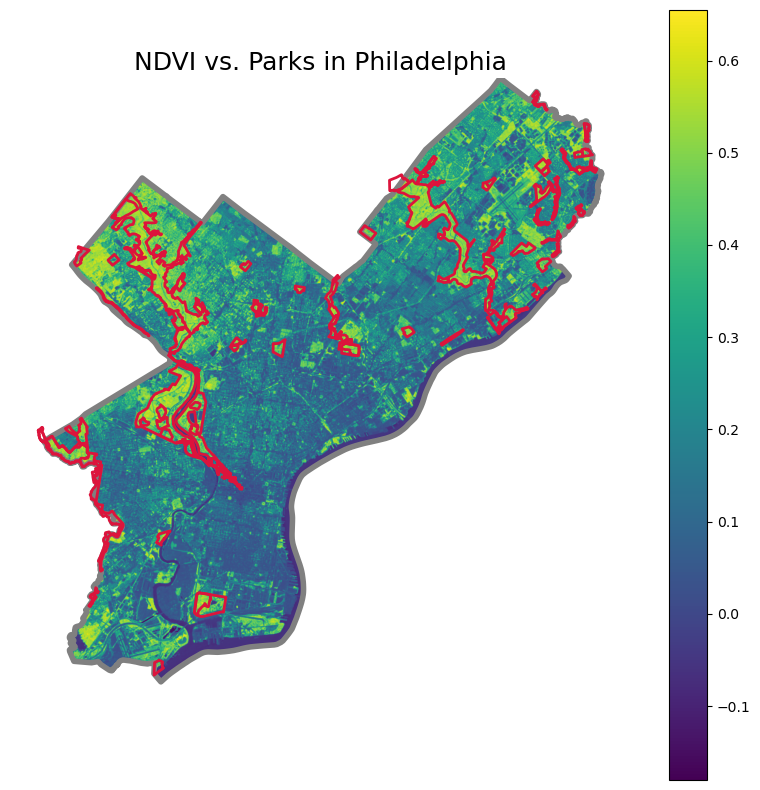

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot NDVI
img = ax.imshow(NDVI, extent=landsat_extent)

# Add the city limits
city_limits.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=4)

# NEW: add the parks
parks.plot(ax=ax, edgecolor="crimson", facecolor="none", linewidth=2)

# Format and add colorbar
plt.colorbar(img)
ax.set_axis_off()
ax.set_title("NDVI vs. Parks in Philadelphia", fontsize=18);

It looks like it worked pretty well!

### How about calculating the median NDVI within the park geometries?

This is called *zonal statistics*. We can use the `rasterstats` package to do this... If you don't have it installed, uncomment the line below to install it. After installation, you can comment the statement. 

In [70]:
# !pip install rasterstats

In [71]:
from rasterstats import zonal_stats

In [72]:
stats = zonal_stats(
    parks,  # The vector data
    NDVI,  # The array holding the raster data
    affine=landsat.transform,  # The affine transform for the raster data
    stats=["mean", "median"],  # The stats to compute
    nodata=np.nan,  # Missing data representation
)

#### The `zonal_stats` function

Zonal statistics of raster values aggregated to vector geometries.

- First argument: vector data
- Second argument: raster data to aggregated
- Also need to pass the affine transform and the names of the stats to compute

In [73]:
stats

[{'mean': 0.5051087300747117, 'median': 0.521160491292894},
 {'mean': 0.441677258928841, 'median': 0.47791901454593105},
 {'mean': 0.48859581791645285, 'median': 0.5084981442485412},
 {'mean': 0.3756264171005127, 'median': 0.42356277391080177},
 {'mean': 0.45897667566035816, 'median': 0.49204860985900256},
 {'mean': 0.4220467885671325, 'median': 0.46829433706341134},
 {'mean': 0.38363107808041097, 'median': 0.416380868090128},
 {'mean': 0.4330996771737791, 'median': 0.4772304906066629},
 {'mean': 0.45350534061220404, 'median': 0.5015001304461257},
 {'mean': 0.44505112880627273, 'median': 0.4701653486700216},
 {'mean': 0.5017048095513129, 'median': 0.5108644957689836},
 {'mean': 0.23745576631277313, 'median': 0.24259729272419628},
 {'mean': 0.31577818701756977, 'median': 0.3306512446567765},
 {'mean': 0.5300954792288528, 'median': 0.5286783042394015},
 {'mean': 0.4138823685577781, 'median': 0.4604562737642586},
 {'mean': 0.48518030764354636, 'median': 0.5319950233699855},
 {'mean': 0.31

In [74]:
len(stats)

63

In [75]:
len(parks)

63

The returned stats object is a list with one entry for each of the vector polygons (the parks dataset)

Let's extract out the median value the list of dictionaries:


In [76]:
median_stats = [stats_dict["median"] for stats_dict in stats]

**Note:** the above cell is equivalent to:

```python
median_stats = []

for stat_dict in stats:
    median_stats.append(stat_dict['median'])
```

Now, we can add it to the original parks GeoDataFrame as a new column:

In [77]:
# Store the median value in the parks data frame
parks["median_NDVI"] = median_stats

In [78]:
parks.head()

OBJECTID               ASSET_NAME                SITE_NAME  \
0         7  Wissahickon Valley Park  Wissahickon Valley Park   
1         8      West Fairmount Park      West Fairmount Park   
2        23           Pennypack Park           Pennypack Park   
3        24      East Fairmount Park      East Fairmount Park   
4        25        Tacony Creek Park        Tacony Creek Park   

                  CHILD_OF ADDRESS  TYPE                             USE_  \
0  Wissahickon Valley Park    None  LAND  REGIONAL_CONSERVATION_WATERSHED   
1      West Fairmount Park          LAND  REGIONAL_CONSERVATION_WATERSHED   
2           Pennypack Park          LAND  REGIONAL_CONSERVATION_WATERSHED   
3      East Fairmount Park          LAND  REGIONAL_CONSERVATION_WATERSHED   
4        Tacony Creek Park          LAND  REGIONAL_CONSERVATION_WATERSHED   

  DESCRIPTION       SQ_FEET      ACREAGE  ZIPCODE  \
0  NO_PROGRAM  9.078309e+07  2084.101326    19128   
1  NO_PROGRAM  6.078159e+07  1395.358890    19131   
2  NO_PROGRAM  6.023748e+07  1382.867808    19152   
3  NO_PROGRAM  2.871642e+07   659.240959    19121   
4  NO_PROGRAM  1.388049e+07   318.653500    19120   

                          ALLIAS NOTES TENANT                    LABEL  \
0                                  MAP   SITE  Wissahickon Valley Park   
1                                  MAP   SITE      West Fairmount Park   
2  Verree Rd Interpretive Center   MAP   SITE           Pennypack Park   
3                                  MAP   SITE      East Fairmount Park   
4                                  MAP   SITE        Tacony Creek Park   

   DPP_ASSET_ID   Shape__Area  Shape__Length  \
0          1357  1.441162e+07   71462.556702   
1          1714  9.631203e+06   25967.819064   
2          1651  9.566914e+06   41487.394790   
3          1713  4.549582e+06   21499.126097   
4          1961  2.201840e+06   19978.610852   

                                            geometry  median_NDVI  
0  MULTIPOLYGON (((484101.476 4431051.989, 484099...     0.521160  
1  MULTIPOLYGON (((482736.681 4428824.579, 482728...     0.477919  
2  MULTIPOLYGON (((497133.192 4434667.95, 497123....     0.508498  
3  POLYGON ((484539.743 4424162.545, 484620.184 4...     0.423563  
4  MULTIPOLYGON (((491712.882 4429633.244, 491713...     0.492049

#### Make a quick histogram of the median values

They are all positive, indicating an abundance of green vegetation...

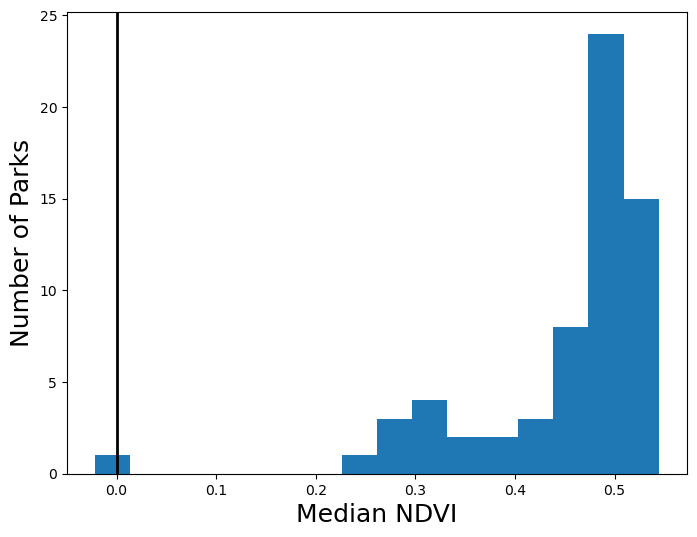

In [80]:
# Initialize
fig, ax = plt.subplots(figsize=(8, 6))

# Plot a quick histogram
ax.hist(parks["median_NDVI"], bins="auto")
ax.axvline(x=0, c="k", lw=2)

# Format
ax.set_xlabel("Median NDVI", fontsize=18)
ax.set_ylabel("Number of Parks", fontsize=18);

#### Let's make a choropleth, too

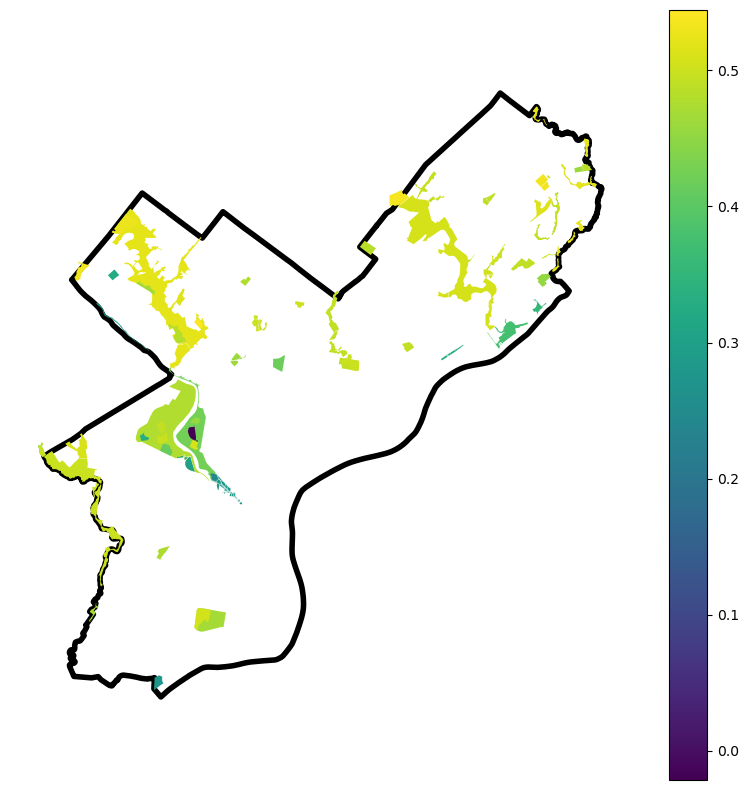

In [81]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the city limits
city_limits.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=4)

# Plot the median NDVI
parks.plot(column="median_NDVI", legend=True, ax=ax, cmap="viridis")

# Format
ax.set_axis_off()

#### Let's make it interactive!

*Make sure to check the crs!*

In [82]:
parks.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

::: {.callout-note}

The CRS is "EPSG:32618" and since it's not in 4326, we'll need to specify the "crs=" keyword when plotting!

:::

In [83]:
# trim to only the columns we want to plot
cols = ["median_NDVI", "SITE_NAME", "geometry"]

# Plot the parks colored by median NDVI
p = parks[cols].hvplot.polygons(
    c="median_NDVI", geo=True, crs=32618, cmap="viridis", hover_cols=["SITE_NAME"]
)

# Plot the city limit boundary
cl = city_limits.hvplot.polygons(
    geo=True,
    crs=32618,
    alpha=0,
    line_alpha=1,
    line_color="black",
    hover=False,
    width=700,
    height=600,
)

# combine!
cl * p

/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/predicates.py:806: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/predicates.py:806: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/predicates.py:806: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffe

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]   (median_NDVI,SITE_NAME)

## Exercise: Measure the median NDVI for each of Philadelphia's neighborhoods

- Once you measure the median value for each neighborhood, try making the following charts:
    - A histogram of the median values for all neighborhoods
    - Bar graphs with the neighborhoods with the 20 highest and 20 lowest values
    - A choropleth showing the median values across the city
    
You're welcome to use matplotlib/geopandas, but encouraged to explore the new hvplot options!

### 1. Load the neighborhoods data

Download the neighborhoods data from [here](data/zillow_neighborhoods.geojson).

In [91]:
# Load the neighborhoods
hoods = gpd.read_file("./data/zillow_neighborhoods.geojson")

### 2. Calculate the median NDVI value for each neighborhood

::: {.callout-warning title="Important"}

Make sure your neighborhoods GeoDataFrame is in the same CRS as the Landsat data!

:::

In [92]:
# Convert to the landsat CRS
hoods = hoods.to_crs(epsg=landsat.crs.to_epsg())

In [93]:
# Calculate the zonal statistics
stats_by_hood = zonal_stats(
    hoods, # Vector data as GeoDataFrame 
    NDVI, # Raster data as Numpy array
    affine=landsat.transform, # Geospatial info via affine transform
    stats=["mean", "median"]
)

In [94]:
stats_by_hood

[{'mean': 0.31392040334687304, 'median': 0.27856594452047934},
 {'mean': 0.18300929138083397, 'median': 0.15571923768967572},
 {'mean': 0.22468445189501648, 'median': 0.17141970412772856},
 {'mean': 0.43065240779519015, 'median': 0.4617488161141866},
 {'mean': 0.318970809622512, 'median': 0.3006904521671514},
 {'mean': 0.25273468406592925, 'median': 0.2483195384843864},
 {'mean': 0.09587147406959982, 'median': 0.08340007053008469},
 {'mean': 0.17925317272000577, 'median': 0.16159209153091308},
 {'mean': 0.16927437879780147, 'median': 0.14856486796785304},
 {'mean': 0.13315183006110315, 'median': 0.0844147036216485},
 {'mean': 0.3032613180748332, 'median': 0.2991018371406554},
 {'mean': 0.30051453671112854, 'median': 0.2983533036011672},
 {'mean': 0.3520402658092766, 'median': 0.36642977306279395},
 {'mean': 0.06850728352663443, 'median': 0.051313743471153465},
 {'mean': 0.1624992167356467, 'median': 0.14594594594594595},
 {'mean': 0.19406263526762074, 'median': 0.19242101469002704},
 {

In [95]:
# Store the median value in the neighborhood data frame
hoods["median_NDVI"] = [stats_dict["median"] for stats_dict in stats_by_hood]

In [96]:
hoods.head()

ZillowName                                           geometry  \
0   Academy Gardens  POLYGON ((500127.271 4434899.076, 500464.133 4...   
1           Airport  POLYGON ((483133.506 4415847.15, 483228.716 44...   
2    Allegheny West  POLYGON ((485837.663 4428133.6, 485834.655 442...   
3           Andorra  POLYGON ((480844.652 4435202.29, 480737.832 44...   
4  Aston Woodbridge  POLYGON ((499266.779 4433715.944, 499265.975 4...   

   median_NDVI  
0     0.278566  
1     0.155719  
2     0.171420  
3     0.461749  
4     0.300690

###  3. Make a histogram of median values

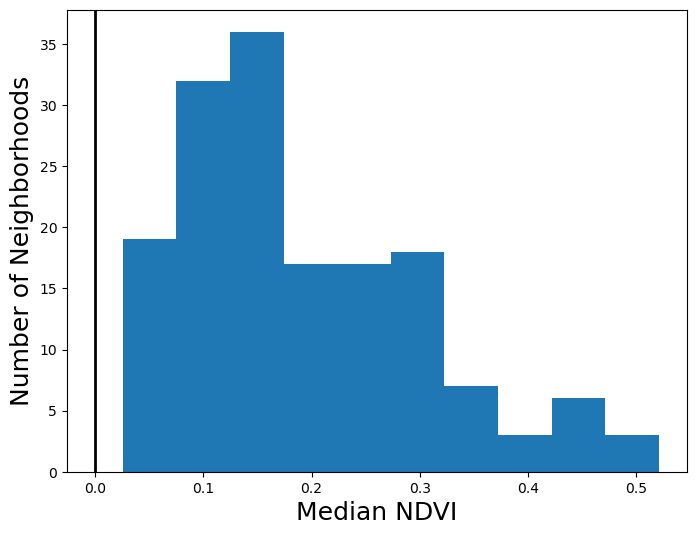

In [99]:
# Initialize
fig, ax = plt.subplots(figsize=(8, 6))

# Plot a quick histogram
ax.hist(hoods["median_NDVI"], bins="auto")
ax.axvline(x=0, c="k", lw=2)

# Format
ax.set_xlabel("Median NDVI", fontsize=18)
ax.set_ylabel("Number of Neighborhoods", fontsize=18);

### 4. Plot a (static) choropleth map

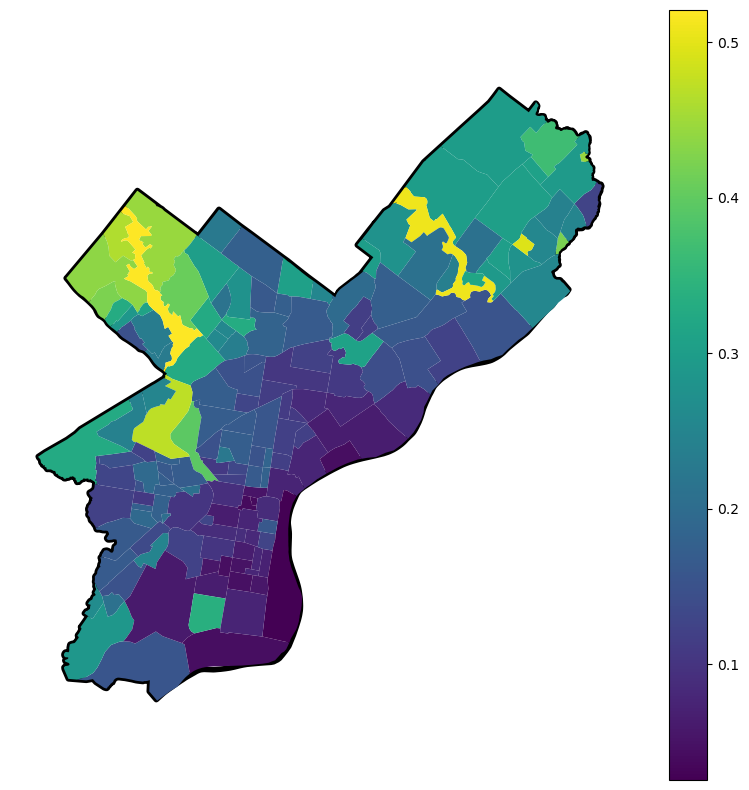

In [100]:
# Initialize
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the city limits
city_limits.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=4)

# Plot the median NDVI
hoods.plot(column="median_NDVI", legend=True, ax=ax)

# Format
ax.set_axis_off()

### 5. Plot an (interactive) choropleth map


You can use your favorite library: hvplot, altair, or geopandas. Solutions will include examples of all three!

#### With hvplot

In [101]:
# trim to only the columns we want to plot
cols = ["median_NDVI", "ZillowName", "geometry"]

# Plot
hoods[cols].hvplot.polygons(
    c="median_NDVI",
    geo=True,
    crs=32618,
    frame_width=600,
    frame_height=600,
    cmap="viridis",
    hover_cols=["ZillowName"],
)

/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/predicates.py:806: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/predicates.py:806: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/predicates.py:806: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/geospatial/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffe

:Polygons   [Longitude,Latitude]   (median_NDVI,ZillowName)

#### With geopandas

In [102]:
# Plot the parks colored by median NDVI
hoods.explore(column="median_NDVI", cmap="viridis", tiles="Cartodb positron")

#### With altair

In [103]:
# trim to only the columns we want to plot
cols = ["median_NDVI", "ZillowName", "geometry"]

(
    alt.Chart(hoods[cols].to_crs(epsg=3857))
    .mark_geoshape()
    .encode(
        color=alt.Color(
            "median_NDVI",
            scale=alt.Scale(scheme="viridis"),
            legend=alt.Legend(title="Median NDVI"),
        ),
        tooltip=["ZillowName", "median_NDVI"],
    )
    .project(type="identity", reflectY=True)
)

alt.Chart(...)

### 6. Challenges

A few extra analysis pieces as an extra challenge. Let's explore the neighborhoods with the highest and lowest median NDVI values.

#### 6A. Plot a bar chart of the neighborhoods with the top 20 largest median values

With hvplot:

In [104]:
# calculate the top 20
cols = ["ZillowName", "median_NDVI"]
top20 = hoods[cols].sort_values("median_NDVI", ascending=False).head(n=20)

top20.hvplot.bar(x="ZillowName", y="median_NDVI", rot=90, height=400)

:Bars   [ZillowName]   (median_NDVI)

With altair:

In [105]:
(
    alt.Chart(top20)
    .mark_bar()
    .encode(
        x=alt.X("ZillowName", sort="-y"),  # Sort in descending order by y
        y="median_NDVI",
        tooltip=["ZillowName", "median_NDVI"],
    )
    .properties(width=800)
)

alt.Chart(...)

#### 6B. Plot a bar chart of the neighborhoods with the bottom 20 largest median values

With hvplot:

In [106]:
cols = ["ZillowName", "median_NDVI"]
bottom20 = hoods[cols].sort_values("median_NDVI", ascending=True).tail(n=20)


bottom20.hvplot.bar(x="ZillowName", y="median_NDVI", rot=90, height=300, width=600)

:Bars   [ZillowName]   (median_NDVI)

With altair:

In [107]:
(
    alt.Chart(bottom20)
    .mark_bar()
    .encode(
        x=alt.X("ZillowName", sort="y"),  # Sort in ascending order by y
        y="median_NDVI",
        tooltip=["ZillowName", "median_NDVI"],
    )
    .properties(width=800)
)

alt.Chart(...)